#  Synchronization of Quantum Clocks

This is the Jupyter notebook used for the calculations presented in "Synchronization of Quantum Clocks"

### required installations

In [3]:
!pip install qutip
!pip install cython
!pip install tdqm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.7 MB/s eta 0:00:00
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=e3d02bba457e567679a81b94b96e7341b27f1f15d7a8d51cc5dd881f2c4d54df
  Stored in directory: /Users/bittner/Library/Caches/pip/wheels/af/02/71/aae0f7ee738abf19498353918ddae0f90a0d6ceb337b0bbc91
Successfully built tdqm


## Code Block

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

from scipy.linalg import sqrtm, eigvals
from tqdm import tqdm

from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,5.0.1
Numpy,1.26.4
SciPy,1.13.0
matplotlib,3.8.4
Number of CPUs,4
BLAS Info,Generic
IPython,8.23.0
Python,"3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]"
OS,posix [darwin]
Cython,3.0.10


In [15]:

def create_adjacency_matrix(graph):
    """
    Generate the adjacency matrix for a given graph.

    Parameters:
    - graph (dict): A dictionary representing the graph, where each key is a node,
                    and the corresponding value is a list of nodes it's connected to.

    Returns:
    - numpy.ndarray: The adjacency matrix of the graph.
    """

    # Extract unique nodes and sort them to maintain consistent order
    nodes = sorted(graph.keys())
    n = len(nodes)

    # Initialize an n x n adjacency matrix with zeros
    adjacency_matrix = np.zeros((n, n), dtype=int) # this would imply each edge is weighted equally

    # Map nodes to their index in the sorted list to fill the matrix correctly
    node_index = {node: i for i, node in enumerate(nodes)}

    # Fill in the adjacency matrix
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            adjacency_matrix[node_index[node], node_index[neighbor]] = 1

    return adjacency_matrix



In [16]:
# Function to calculate the entanglement of formation given the concurrence
def entanglement_of_formation(concurrence):
    if concurrence <= 0:
        return 0
    elif concurrence >= 1:
        return 1
    h = lambda x: -x * np.log2(x + 1e-12) - (1 - x) * np.log2(1 - x + 1e-12)  # Binary entropy function
    sqrt_term = np.sqrt(1 - concurrence**2)
    return h((1 + max(0, sqrt_term)) / 2)  # Calculate entanglement of formation

# Function to calculate the concurrence of a density matrix
def calculate_concurrence(rho):
    rho = rho.full().astype(np.complex128)
    R = sqrtm(sqrtm(rho) @ rho.conj().T @ sqrtm(rho))
    eigvals_R = np.sort(np.real(eigvals(R)))[::-1]
    return max(0, eigvals_R[0] - sum(eigvals_R[1:]))

# Function to calculate the quantum discord of a two-qubit state
def quantum_discord(rho_AB):
    eigvals, eigvecs = rho_AB.eigenstates()
    ancilla_dim = 2
    psi_purified = sum(np.sqrt(eigvals[i]) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
    rho_AC = psi_purified.ptrace([0, 2])
    rho_B = rho_AB.ptrace([1])
    S_rho_B = entropy_vn(rho_B, base=2)
    S_rho_AB = entropy_vn(rho_AB, base=2)
    concurrence_rho_AC = calculate_concurrence(rho_AC)
    E_C = entanglement_of_formation(concurrence_rho_AC)
    return max(0, S_rho_B - S_rho_AB + E_C)

In [17]:
# Example Bell state density matrix
bell_state = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
rho_bell = bell_state * bell_state.dag()

# Example maximally mixed state
rho_mixed = qeye(4) / 4
rho_mixed.dims = [[2, 2], [2, 2]]

# Original density matrix
data = [
    [0.31478817, 0.05239977, 0.14084707, 0.16087211],
    [0.05239977, 0.11181522, 0.08096762, 0.03145797],
    [0.14084707, 0.08096762, 0.37352824, 0.17620866],
    [0.16087211, 0.03145797, 0.17620866, 0.19986838]
]
rho_AB = Qobj(data, dims=[[2, 2], [2, 2]])

states = [("Bell State", rho_bell), ("Maximally Mixed State", rho_mixed), ("Original Density Matrix", rho_AB)]

for name, state in tqdm(states, desc="Calculating Quantum Discord"):
    discord = quantum_discord(state)
    print(f"Quantum Discord for {name}: {discord}")

Calculating Quantum Discord: 100%|████████████████| 3/3 [00:00<00:00, 55.99it/s]

Quantum Discord for Bell State: 0.9999999999985936
Quantum Discord for Maximally Mixed State: 0
Quantum Discord for Original Density Matrix: 0


In [18]:
# dynamics code 

def Synchro(N, hx,hz, Jx, Jy, Jz, psi0, tlist, gamma1,gamma, xi_matrix):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    sm = destroy(2)
    sp = sm.dag()


    sx_list = []
    sy_list = []
    sz_list = []

    sp_list = []
    sm_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

        op_list[n] = sp
        sp_list.append(tensor(op_list))
        op_list[n] = sm
        sm_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H +=  0.5 * (-hz[n] * sz_list[n] + hx[n] * sx_list[n])

    # interaction terms
    for n in range(N-1):
        H +=  0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  0.5 * Jz[n] * sz_list[n] * sz_list[n+1]


    c_op_list = []

    # local dephasing
    for k in range(N):
        c_op_list.append(np.sqrt(gamma1)*sz_list[k]) 
    ev, evec = np.linalg.eig(xi_matrix)

    # correlated kicks
    for n in range(N):
    
      cop = 0
      for k in range(N):
        cop += evec[n,k]*sm_list[k]*np.sqrt(gamma[k])
      c_op_list.append(ev[n]*cop)



    # evolve and calculate expectation values
    
    result = mesolve(H, psi0, tlist, c_op_list, sz_list)
    

    return result.expect






In [19]:
def SynchroBloch(N, hx,hz, Jx, Jy, Jz, psi0, tlist, gamma1, gamma, xi_matrix):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    sm = destroy(2)
    sp = sm.dag()


    sx_list = []
    sy_list = []
    sz_list = []

    sp_list = []
    sm_list = []
    sop_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))
        sop_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))
        sop_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        sop_list.append(tensor(op_list))

        op_list[n] = sp
        sp_list.append(tensor(op_list))
        op_list[n] = sm
        sm_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H +=  0.5 * (-hz[n] * sz_list[n] + hx[n] * sx_list[n])

    # interaction terms
    for n in range(N-1):
        H +=  0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  0.5 * Jz[n] * sz_list[n] * sz_list[n+1]


    c_op_list = []

    # local dephasing
    for k in range(N):
        c_op_list.append(np.sqrt(gamma1)*sz_list[k]) 
    ev, evec = np.linalg.eig(xi_matrix)

    # correlated kicks
    for n in range(N):
    
      cop = 0
      for k in range(N):
        cop += evec[n,k]*sm_list[k]*np.sqrt(gamma[k])
      c_op_list.append(ev[n]*cop)



    # evolve and calculate expectation values
    
    result = mesolve(H, psi0, tlist, c_op_list, sop_list)
    

    return result.expect






In [96]:
def SynchroBlochStationary(N, hx,hz, Jx, Jy, Jz, gamma1,gamma, xi_matrix):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    sm = destroy(2)
    sp = sm.dag()


    sx_list = []
    sy_list = []
    sz_list = []

    sp_list = []
    sm_list = []
    sop_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))
        sop_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))
        sop_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        sop_list.append(tensor(op_list))

        op_list[n] = sp
        sp_list.append(tensor(op_list))
        op_list[n] = sm
        sm_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H +=  0.5 * (-hz[n] * sz_list[n] + hx[n] * sx_list[n])

    # interaction terms
    for n in range(N-1):
        H +=  0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  0.5 * Jz[n] * sz_list[n] * sz_list[n+1]


    c_op_list = []

    # local dephasing
    for k in range(N):
        c_op_list.append(np.sqrt(gamma1)*sz_list[k]) 
    ev, evec = np.linalg.eig(xi_matrix)

    # correlated kicks
    for n in range(N):
    
      cop = 0
      for k in range(N):
        cop += evec[n,k]*sm_list[k]*np.sqrt(gamma[k])
      c_op_list.append(ev[n]*cop)



    # evolve and calculate expectation values
    
    #result = mesolve(H, psi0, tlist, c_op_list, sop_list)
    rho_ss = qutip.steadystate(H, c_op_list)
    sx1_ss = expect(sx_list[0], rho_ss)
    sy1_ss = expect(sy_list[0], rho_ss)
    sz1_ss = expect(sz_list[0], rho_ss)
    sx2_ss = expect(sx_list[1], rho_ss)
    sy2_ss = expect(sy_list[1], rho_ss)
    sz2_ss = expect(sz_list[1], rho_ss)
    I_full = qutip.entropy_mutual(rho_ss,0,1)


    rhoA = rho_ss.ptrace(1)
    rhoB = rho_ss.ptrace(0)
    econBA = qutip.entropy_conditional(rho_ss,1)
    econAB = qutip.entropy_conditional(rho_ss,0)


    SvnB = qutip.entropy_vn(rhoB)
    SvnA = qutip.entropy_vn(rhoA)
    Ja = SvnB - econBA
    Jb = SvnA - econAB


    rho_diag = rho_ss.full() * np.eye(len(rho_ss.full()))
    rho_class = qutip.Qobj(rho_diag, dims=rho_ss.dims)

    I_class = qutip.entropy_mutual(rho_class,0,1)
    

    deg = I_full-I_class

    discord = quantum_discord(rho_ss)

    
    final = [sx1_ss,sy1_ss,sz1_ss,sx2_ss,sy2_ss,sz2_ss,I_full,I_class,deg,discord]

    return final


# Function to calculate the quantum discord of a two-qubit state
def quantum_discord(rho_AB):
    eigvals, eigvecs = rho_AB.eigenstates()
    ancilla_dim = 2
    psi_purified = sum(np.sqrt(eigvals[i]) * tensor(eigvecs[i], basis(ancilla_dim, 0)) for i in range(len(eigvals)))
    rho_AC = psi_purified.ptrace([0, 2])
    rho_B = rho_AB.ptrace([1])
    S_rho_B = entropy_vn(rho_B, base=2)
    S_rho_AB = entropy_vn(rho_AB, base=2)
    concurrence_rho_AC = calculate_concurrence(rho_AC)
    E_C = entanglement_of_formation(concurrence_rho_AC)
    return max(0, S_rho_B - S_rho_AB + E_C)


In [72]:
def SynchroDensityMatrix(N, hx,hz, Jx, Jy, Jz, psi0, tlist, gamma1,gamma, xi_matrix):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    sm = destroy(2)
    sp = sm.dag()


    sx_list = []
    sy_list = []
    sz_list = []

    sp_list = []
    sm_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

        op_list[n] = sp
        sp_list.append(tensor(op_list))
        op_list[n] = sm
        sm_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H +=  0.5 * (-hz[n] * sz_list[n] + hx[n] * sx_list[n])

    # interaction terms
    for n in range(N-1):
        H +=  0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  0.5 * Jz[n] * sz_list[n] * sz_list[n+1]


    c_op_list = []

    # local dephasing
    for k in range(N):
        c_op_list.append(np.sqrt(gamma1)*sz_list[k]) 
    ev, evec = np.linalg.eig(xi_matrix)

    # correlated kicks
    for n in range(N):
    
      cop = 0
      for k in range(N):
        cop += evec[n,k]*sm_list[k]*np.sqrt(gamma[k])
      c_op_list.append(ev[n]*cop)



    # evolve and calculate expectation values
    
    result = mesolve(H, psi0, tlist, c_op_list, [],options={"progress_bar":"enhanced" })
    

    return result.states






In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

def calculate_phase_synchronization(x, y):
    """
    Calculate the phase synchronization between two time series.
    
    Parameters:
    x (array-like): First time series.
    y (array-like): Second time series.
    
    Returns:
    float: Phase synchronization value.
    """
    # Compute the analytic signal using Hilbert transform
    analytic_signal_x = hilbert(x)
    analytic_signal_y = hilbert(y)
    
    # Extract the instantaneous phase
    phase_x = np.angle(analytic_signal_x)
    phase_y = np.angle(analytic_signal_y)
    
    # Calculate phase difference
    phase_diff = phase_x - phase_y
    
    # Compute phase synchronization index
    phase_synchronization_index = np.abs(np.mean(np.exp(1j * phase_diff)))
    
    return phase_synchronization_index, phase_diff, phase_x, phase_y




### Calculate coherence between two signals

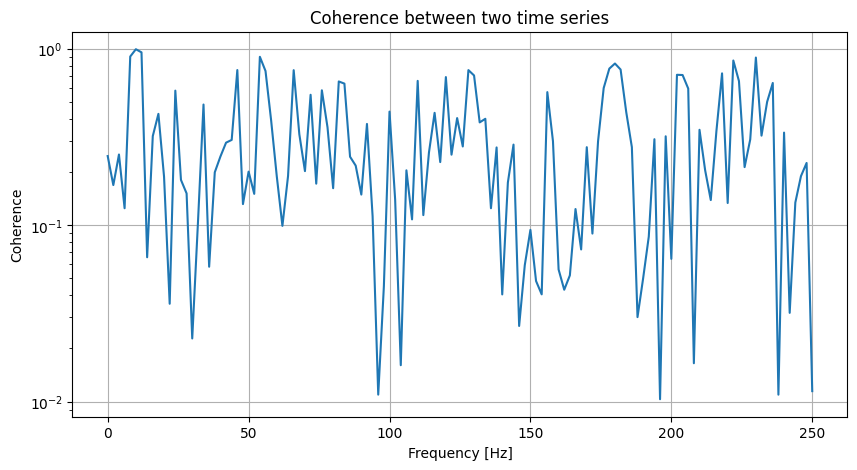

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import coherence

# Generate example time series
fs = 500  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
x = np.sin(2 * np.pi * 10 * t)  # Sine wave at 10 Hz
y = np.sin(2 * np.pi * 10 * t + np.pi / 4)  # Sine wave at 10 Hz with a phase shift

# Add some noise
x += np.random.normal(0, 0.5, x.shape)
y += np.random.normal(0, 0.5, y.shape)

# Calculate coherence
f, Cxy = coherence(x, y, fs, nperseg=fs//2)

# Plot coherence
plt.figure(figsize=(10, 5))
plt.semilogy(f, Cxy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Coherence between two time series')
plt.grid()
plt.show()



### Calculate mutual info between two time series

In [24]:
!pip install scikit-learn

import numpy as np
from sklearn.metrics import mutual_info_score

def calculate_mutual_information(x, y, bins=10):
    """
    Calculate the mutual information between two time series.
    
    Parameters:
    x (array-like): First time series.
    y (array-like): Second time series.
    bins (int): Number of bins for discretizing the time series.
    
    Returns:
    float: Mutual information value.
    """
    # Discretize the time series
    x_discretized = np.digitize(x, bins=np.histogram_bin_edges(x, bins=bins))
    y_discretized = np.digitize(y, bins=np.histogram_bin_edges(y, bins=bins))
    
    # Calculate mutual information
    mi = mutual_info_score(x_discretized, y_discretized)
    return mi

# Example time series
x = np.sin(np.linspace(0, 2 * np.pi, 100))
y = np.sin(np.linspace(0, 2 * np.pi, 100) + np.pi / 4)

# Calculate mutual information
mutual_information = calculate_mutual_information(x, y)
print("Mutual Information:", mutual_information)


Mutual Information: 1.0166001661483146


Phase Synchronization Index (PSI): 0.7050333366578987
Phase Locking Value (PLV): 0.7050333366578987


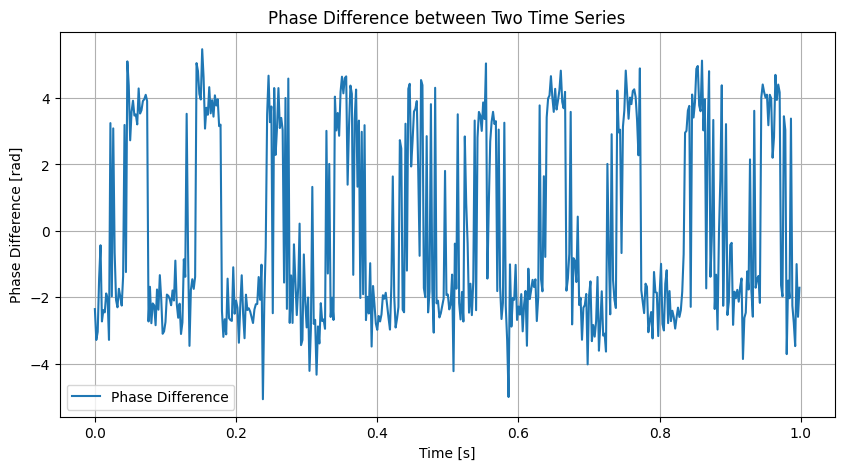

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

def calculate_phase_synchronization2(x, y):
    """
    Calculate the phase synchronization between two time series.
    
    Parameters:
    x (array-like): First time series.
    y (array-like): Second time series.
    
    Returns:
    float: Phase synchronization index (PSI).
    float: Phase locking value (PLV).
    array-like: Instantaneous phase difference.
    """
    # Compute the analytic signal using Hilbert transform
    analytic_signal_x = hilbert(x)
    analytic_signal_y = hilbert(y)
    
    # Extract the instantaneous phase
    phase_x = np.angle(analytic_signal_x)
    phase_y = np.angle(analytic_signal_y)
    
    # Calculate phase difference
    phase_diff = phase_x - phase_y
    
    # Compute phase synchronization index (PSI)
    psi = np.abs(np.mean(np.exp(1j * phase_diff)))
    
    # Compute phase locking value (PLV)
    plv = np.abs(np.mean(np.exp(1j * phase_diff)))
    
    return psi, plv, phase_diff, phase_x, phase_y

# Generate example time series
fs = 500  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
x = np.sin(2 * np.pi * 10 * t)  # Sine wave at 10 Hz
y = np.cos(2 * np.pi * 10 * t + np.pi / 4)  # Sine wave at 10 Hz with a phase shift

# Add some noise
x += np.random.normal(0, 0.5, x.shape)
y += np.random.normal(0, 0.5, y.shape)

# Calculate phase synchronization
psi, plv, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x, y)
print("Phase Synchronization Index (PSI):", psi)
print("Phase Locking Value (PLV):", plv)

# Plot the phase difference
plt.figure(figsize=(10, 5))
plt.plot(t, phase_diff, label='Phase Difference')
plt.xlabel('Time [s]')
plt.ylabel('Phase Difference [rad]')
plt.title('Phase Difference between Two Time Series')
plt.legend()
plt.grid()
plt.show()


### calculate the classical correlation and estimate degree of quantum-ness

In [26]:
import qutip as qt
import numpy as np

def mutual_information(rho):
    """
    Calculate the mutual information I(A:B) of a bipartite density matrix rho.
    """
    return qt.entropy_mutual(rho, [0], [1])

def strip_off_diagonal(rho):
    """
    Remove the off-diagonal elements of a density matrix rho.
    """
    rho_diag = rho.full() * np.eye(len(rho.full()))
    return qt.Qobj(rho_diag, dims=rho.dims)

def degree_of_quantumness(rho):
    """
    Calculate the Degree of Quantumness of a bipartite density matrix rho and print the matrices.
    """
    #print(f"\n{label} Density Matrix:\n", rho.full())
    
    I_total = mutual_information(rho)
    rho_classical = strip_off_diagonal(rho)
    
    #print(f"\nStripped {label} Density Matrix:\n", rho_classical.full())
    
    I_classical = mutual_information(rho_classical)
    degree_of_quantumness = I_total - I_classical
    
    #print(f"\nDegree of Quantumness for {label}: {degree_of_quantumness}")
    return degree_of_quantumness



## Calculations

In [90]:
#
# set up the calculation
#

N = 2            # number of spins

# array of spin energy splittings and coupling strengths. here we use
# uniform parameters, but in general we don't have to

pi  = np.pi
hz  = 1.0 * np.ones(N)
hx = 1.0 *  np.ones(N)
Jz = 0. * np.ones(N)
Jx = .25* np.ones(N)
Jy = .25* np.ones(N)



#-----BATH PARAMETERIZATION -------------
# Local Bath Parameters for
# dE - gamma E dt + sigma dW


gamma_val = .050
gamma =gamma_val * np.ones(N)
sigma = 0.1 * np.ones(N)
gamma1 = 0.0
#
# Graph for Bath correlation.


graph = {
    0:[1],
    1:[0]
}

cor_matrix = create_adjacency_matrix(graph)
ident = np.identity(N)


# pass the xi matrix, sigma, and gamma to the Solver and have the
# collapse operators defined within the subroutine.

tlist = np.linspace(0, 100.0, 1000)


# you need to give it an initial excitation:
vacc_list = []
sp_list = []
for n in range(N):
    sp_list.append(qeye(2))
    vacc_list.append(basis(2,0))
vacc = tensor(vacc_list)
vacc_list[0] = basis(2,1)
psi0=tensor(vacc_list)



xi_list = np.linspace(-1,1,101)
site1x = []
site1y = []
site1z = []
site2x = []
site2y = []
site2z = []
steadystate = []

for n in range(len(xi_list)):
    xi_val = xi_list[n] 
    xi_matrix = xi_val*cor_matrix + ident
    print(" xi :", xi_val)
    testrun1 = SynchroBloch(N, hx,hz, Jx, Jy, Jz, psi0, tlist, gamma1,gamma, xi_matrix)
    ss = SynchroBlochStationary(N, hx,hz, Jx, Jy, Jz, gamma1,gamma, xi_matrix)
    site1x.append(np.real(testrun1[0]))
    site1y.append(np.real(testrun1[1]))
    site1z.append(np.real(testrun1[2]))
    site2x.append(np.real(testrun1[3]))
    site2y.append(np.real(testrun1[4]))
    site2z.append(np.real(testrun1[5]))
    steadystate.append(ss)
    

stack1x = []
stack2x = []
stack1y = []
stack2y = []
stack1z = []
stack2z = []
for n in range(len(xi_list)):
    stack1x.append(site1x[n])
    stack2x.append(site2x[n])
    stack1y.append(site1y[n])
    stack2y.append(site2y[n])
    stack1z.append(site1z[n])
    stack2z.append(site2z[n])

index = str(gamma_val)

# Create the filename
filename1x = f"Noise_Synchro1x_gamma="+index+".csv"
filename1y = f"Noise_Synchro1y_gamma="+index+".csv"
filename1z = f"Noise_Synchro1z_gamma="+index+".csv"
filename2x = f"Noise_Synchro2x_gamma="+index+".csv"
filename2y = f"Noise_Synchro2y_gamma="+index+".csv"
filename2z = f"Noise_Synchro2z_gamma="+index+".csv"
filename_ss = f"NoiseSynchro_SS_gamma="+index+".csv"


print("data saved to :",filename1x)
print("data saved to :",filename2x)
print("data saved to :",filename1y)
print("data saved to :",filename2y)
print("data saved to :",filename1z)
print("data saved to :",filename2z)
print("data saved to :",filename_ss)


# Save the array as a CSV file
np.savetxt(filename1x, stack1x, delimiter=',')
np.savetxt(filename2x, stack2x, delimiter=',')
np.savetxt(filename1y, stack1y, delimiter=',')
np.savetxt(filename2y, stack2y, delimiter=',')
np.savetxt(filename1z, stack1z, delimiter=',')
np.savetxt(filename2z, stack2z, delimiter=',')
np.savetxt(filename_ss,steadystate,delimiter=',')

print("done")


 xi : -1.0
 xi : -0.98
 xi : -0.96
 xi : -0.94
 xi : -0.92
 xi : -0.9
 xi : -0.88
 xi : -0.86
 xi : -0.84
 xi : -0.8200000000000001
 xi : -0.8
 xi : -0.78
 xi : -0.76
 xi : -0.74
 xi : -0.72
 xi : -0.7
 xi : -0.6799999999999999
 xi : -0.6599999999999999
 xi : -0.64
 xi : -0.62
 xi : -0.6
 xi : -0.5800000000000001
 xi : -0.56
 xi : -0.54
 xi : -0.52
 xi : -0.5
 xi : -0.48
 xi : -0.45999999999999996
 xi : -0.43999999999999995
 xi : -0.42000000000000004
 xi : -0.4
 xi : -0.38
 xi : -0.36
 xi : -0.33999999999999997
 xi : -0.31999999999999995
 xi : -0.29999999999999993
 xi : -0.28
 xi : -0.26
 xi : -0.24
 xi : -0.21999999999999997
 xi : -0.19999999999999996
 xi : -0.17999999999999994
 xi : -0.16000000000000003
 xi : -0.14
 xi : -0.12
 xi : -0.09999999999999998
 xi : -0.07999999999999996
 xi : -0.05999999999999994
 xi : -0.040000000000000036
 xi : -0.020000000000000018
 xi : 0.0
 xi : 0.020000000000000018
 xi : 0.040000000000000036
 xi : 0.06000000000000005
 xi : 0.08000000000000007
 xi : 0.

## Analysis

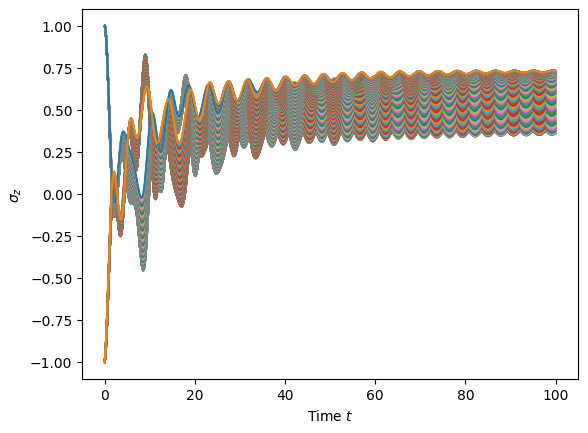

In [46]:
plt.figure()

for m in range(len(xi_list)):
    plt.plot(tlist, site2z[m])
    plt.plot(tlist, site1z[m])

plt.xlabel(r'Time $t$')
plt.ylabel(r'$\sigma_z$')
plt.show()

-1.0
Phase Synchronization Index for full series: 0.7452259904304526
Phase Synchronization Index for last 100:  0.9950678383971764


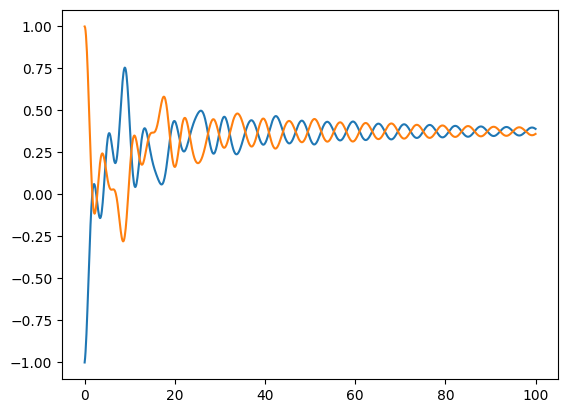

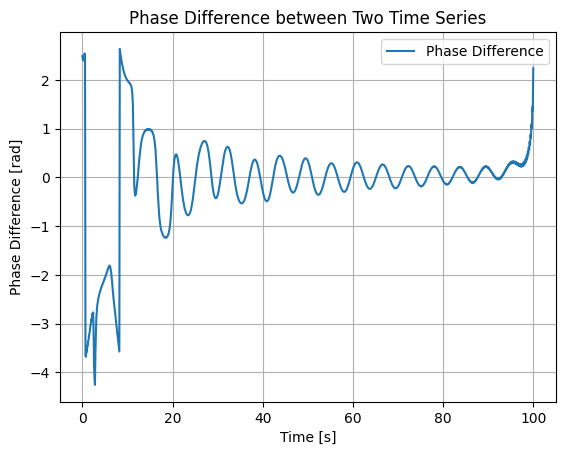

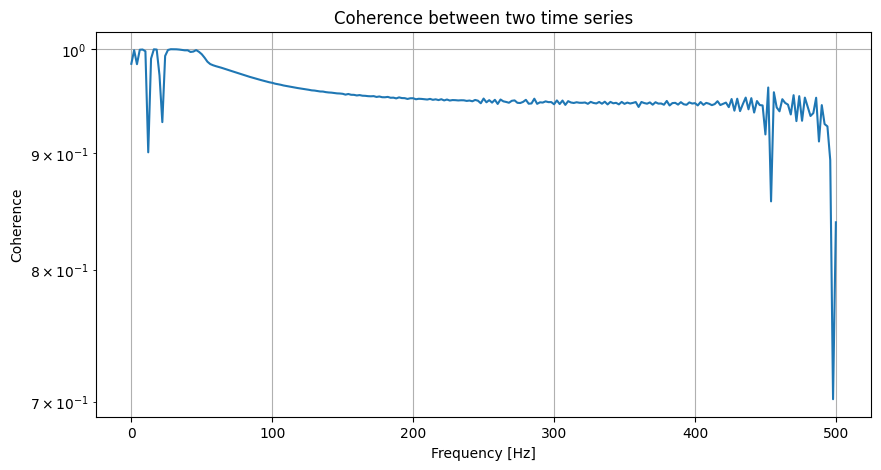

Mutual Information full series = : 0.47102801919910353
mutual info for last 100 steps = : 2.1167771223748573
mutual info for last 50 steps = : 2.079442875243834


In [47]:
n = 0

print(xi_list[n])

plt.figure()
plt.plot(tlist,site1z[n])
plt.plot(tlist,site2z[n])


plt.figure()
x = site1z[n]
y = site2z[n]
# Calculate phase synchronization
psi, pd,phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x, y)
print("Phase Synchronization Index for full series:", psi)

psi, pd, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x[-100:], y[-100:])
print("Phase Synchronization Index for last 100: ", psi)


psi, pd,phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x, y)


# Plot the phase difference

plt.plot(tlist, phase_diff, label='Phase Difference')
plt.xlabel('Time [s]')
plt.ylabel('Phase Difference [rad]')
plt.title('Phase Difference between Two Time Series')
plt.legend()
plt.grid()
plt.show()



fs = len(tlist)

# Calculate coherence
f, Cxy = coherence(x, y, fs, nperseg=fs//2)

# Plot coherence
plt.figure(figsize=(10, 5))
plt.semilogy(f, Cxy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Coherence between two time series')
plt.grid()
plt.show()


# Calculate mutual information
mutual_information = calculate_mutual_information(x, y)
print("Mutual Information full series = :", mutual_information)

print("mutual info for last 100 steps = :",calculate_mutual_information(x[-100:],y[-100:]))
print("mutual info for last 50 steps = :",calculate_mutual_information(x[-50:],y[-50:]))



Phase Synchronization Index: 0.8907872822254796


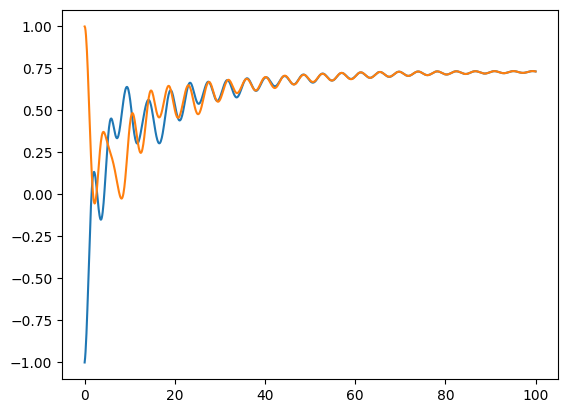

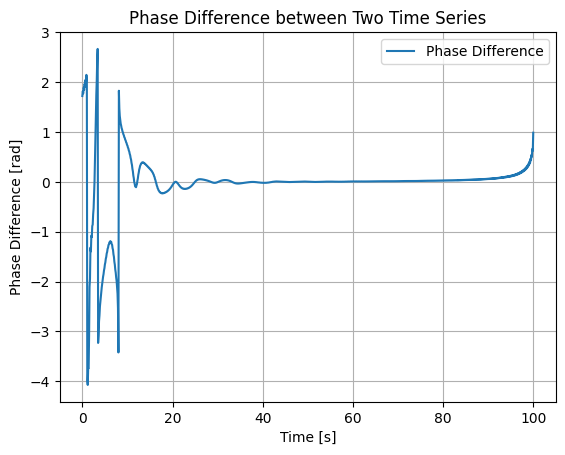

Phase Synchronization Index (PSI): 0.8907872822254796
Phase Locking Value (PLV): 0.8907872822254796
Phase Synchronization Index for last 100:  0.8907872822254796


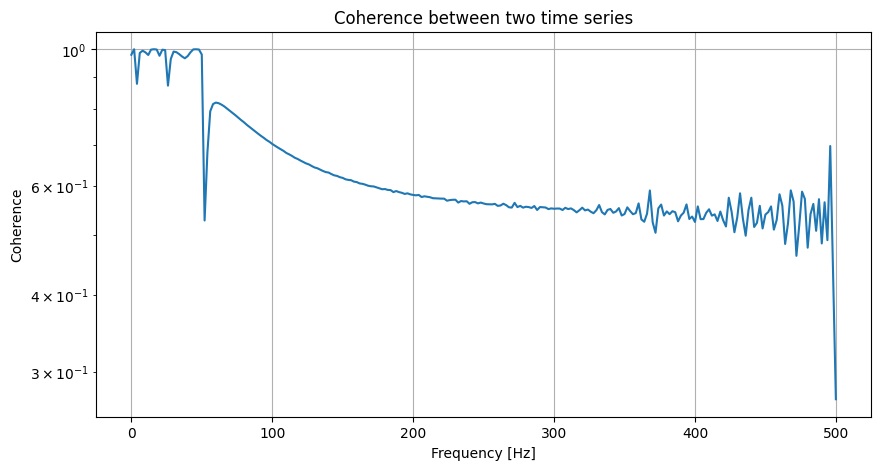

Mutual Information: 0.44311521232834616


In [28]:

last = len(xi_list)-1
plt.figure()
plt.plot(tlist,site1z[last])
plt.plot(tlist,site2z[last])


plt.figure()
x = site1z[last]
y = site2z[last]
# Calculate phase synchronization
psi, plv, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x, y)
print("Phase Synchronization Index:", psi)

# Plot the phase difference

plt.plot(tlist, phase_diff, label='Phase Difference')
plt.xlabel('Time [s]')
plt.ylabel('Phase Difference [rad]')
plt.title('Phase Difference between Two Time Series')
plt.legend()
plt.grid()
plt.show()



# Calculate phase synchronization
psi, plv, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x, y)
print("Phase Synchronization Index (PSI):", psi)
print("Phase Locking Value (PLV):", plv)

#psi, plv, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x[-100:], y[-100:])
psi, plv, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x, y)

print("Phase Synchronization Index for last 100: ", psi)


fs = len(tlist)

# Calculate coherence
f, Cxy = coherence(x, y, fs, nperseg=fs//2)

# Plot coherence
plt.figure(figsize=(10, 5))
plt.semilogy(f, Cxy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Coherence between two time series')
plt.grid()
plt.show()


# Calculate mutual information
mutual_information = calculate_mutual_information(x, y)
print("Mutual Information:", mutual_information)



-1.0
Phase Synchronization Index: 0.7452259904304526


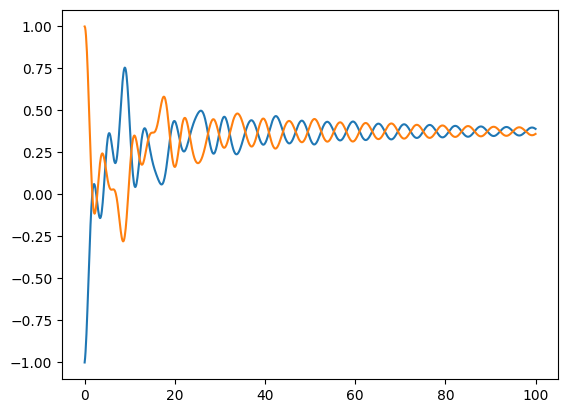

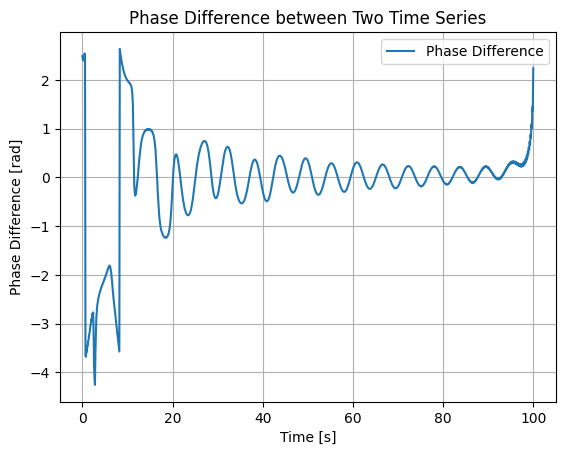

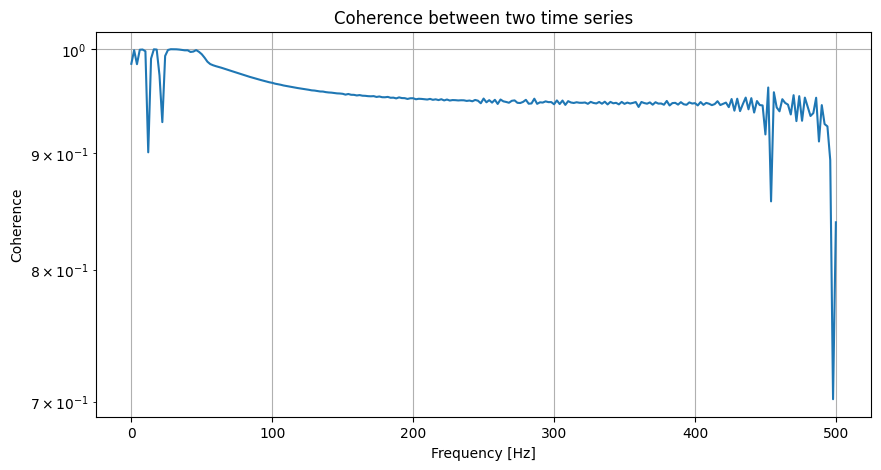

Mutual Information: 0.47102801919910353
Phase Synchronization Index for full series: 0.7452259904304526
Phase Synchronization Index for last 100:  0.9950678383971764


In [71]:
n = 0
xi_list[n]
print(xi_list[n])
plt.figure()
plt.plot(tlist,site1z[n])
plt.plot(tlist,site2z[n])


plt.figure()
x = site1z[n]
y = site2z[n]
# Calculate phase synchronization
psi, phase_diff, phase_x, phase_y = calculate_phase_synchronization(x, y)
print("Phase Synchronization Index:", psi)

# Plot the phase difference

plt.plot(tlist, phase_diff, label='Phase Difference')
plt.xlabel('Time [s]')
plt.ylabel('Phase Difference [rad]')
plt.title('Phase Difference between Two Time Series')
plt.legend()
plt.grid()
plt.show()



fs = len(tlist)

# Calculate coherence
f, Cxy = coherence(x, y, fs, nperseg=fs//2)

# Plot coherence
plt.figure(figsize=(10, 5))
plt.semilogy(f, Cxy)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Coherence between two time series')
plt.grid()
plt.show()


# Calculate mutual information
mutual_information = calculate_mutual_information(x, y)
print("Mutual Information:", mutual_information)


# Calculate phase synchronization
psi, phase_diff, phase_x, phase_y = calculate_phase_synchronization(x, y)
print("Phase Synchronization Index for full series:", psi)

psi, phase_diff, phase_x, phase_y = calculate_phase_synchronization(x[-100:], y[-100:])
print("Phase Synchronization Index for last 100: ", psi)


96.0960960960961
 Xi value =  -1.0
 Xi value =  -0.98
 Xi value =  -0.96
 Xi value =  -0.94
 Xi value =  -0.92
 Xi value =  -0.9
 Xi value =  -0.88
 Xi value =  -0.86
 Xi value =  -0.84
 Xi value =  -0.8200000000000001
 Xi value =  -0.8
 Xi value =  -0.78
 Xi value =  -0.76
 Xi value =  -0.74
 Xi value =  -0.72
 Xi value =  -0.7
 Xi value =  -0.6799999999999999
 Xi value =  -0.6599999999999999
 Xi value =  -0.64
 Xi value =  -0.62
 Xi value =  -0.6
 Xi value =  -0.5800000000000001
 Xi value =  -0.56
 Xi value =  -0.54
 Xi value =  -0.52
 Xi value =  -0.5
 Xi value =  -0.48
 Xi value =  -0.45999999999999996
 Xi value =  -0.43999999999999995
 Xi value =  -0.42000000000000004
 Xi value =  -0.4
 Xi value =  -0.38
 Xi value =  -0.36
 Xi value =  -0.33999999999999997
 Xi value =  -0.31999999999999995
 Xi value =  -0.29999999999999993
 Xi value =  -0.28
 Xi value =  -0.26
 Xi value =  -0.24
 Xi value =  -0.21999999999999997
 Xi value =  -0.19999999999999996
 Xi value =  -0.17999999999999994
 

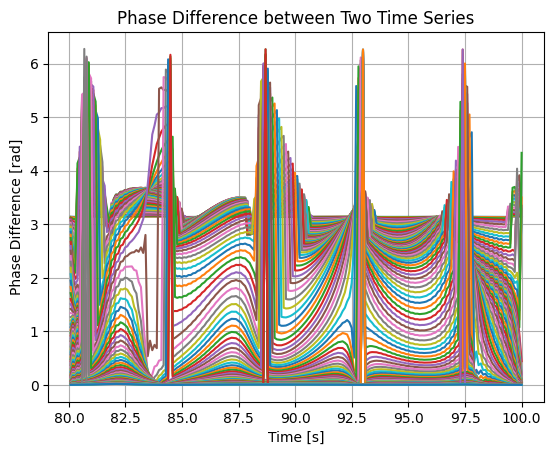

In [29]:
# putting it all together

plt.figure()
phi_diff = []
plv_list = []

fs = len(tlist)
ord = []

nsnap = 40
print(tlist[-nsnap])
for n in range(len(xi_list)):
    
    print(" Xi value = ",xi_list[n])
    x = site1z[n]
    y = site2z[n]
    lenx = len(x)
    
    

 
# Calculate phase synchronization of last 25% of the data
    nlast = 200
    meanx = np.mean(x[-nlast:])
    meany = np.mean(y[-nlast:])
    
    psi, plv, phase_diff, phase_x, phase_y = calculate_phase_synchronization2(x[-nlast:]-meanx, y[-nlast:]-meany)
    phi_diff.append(phase_diff)
    ord.append(abs(phase_diff[-nsnap]))
    plv_list.append(plv)
    #print("Phase Synchronization Index:", psi)
    #print("Phase Locking Value: ",plv)
    plt.plot(tlist[-nlast:], abs(phase_diff), label=xi_list[n])


index = str(gamma_val)
# Create the filenames
filename1 = f"Noise_Synchro_order_param_gamma="+index+".csv"
filename2 = f"Noise_Synchro_PLV_gamma="+index+".csv"
filename3 = f"Noise_Synchro_Phase_diff_gamma="+index+".csv"

print("Order param data saved to :",filename1)
print("PLV data saved to :",filename2)
print("Phase Differences saved to :",filename3)

# Save the array as a CSV file
np.savetxt(filename1, ord, delimiter=',')
np.savetxt(filename2, plv_list, delimiter=',')
np.savetxt(filename3, phase_diff,delimiter=',')

# Plot the phase difference

plt.xlabel('Time [s]')
plt.ylabel('Phase Difference [rad]')
plt.title('Phase Difference between Two Time Series')
#plt.legend()
plt.grid()
plt.show()

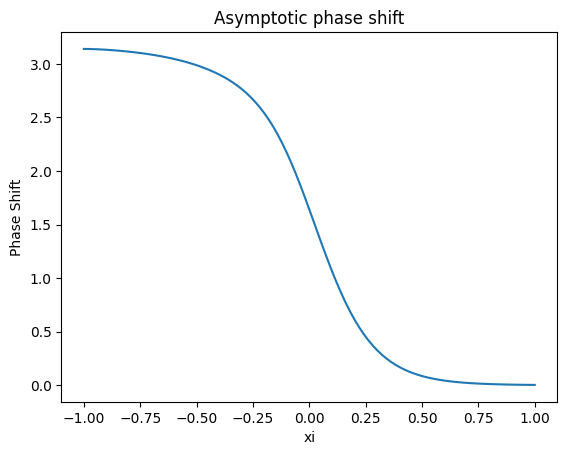

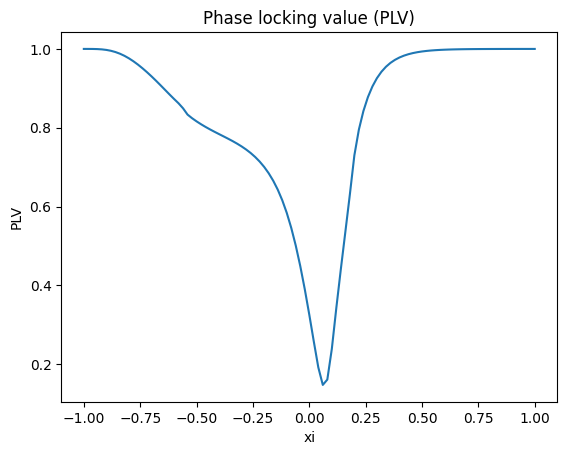

In [30]:
plt.figure()

plt.title('Asymptotic phase shift')
plt.plot(xi_list,ord)
plt.xlabel(f"xi")
plt.ylabel('Phase Shift')
plt.show()

plt.figure()
plt.title('Phase locking value (PLV)')
plt.plot(xi_list,plv_list)
plt.xlabel("xi")
plt.ylabel('PLV')
plt.show()

##  mapping out the steady-state points--1-July

In [91]:
# #
# set up the calculation
#

N = 2            # number of spins

# array of spin energy splittings and coupling strengths. here we use
# uniform parameters, but in general we don't have to
hz  = -1.0 * np.ones(N)
hx =  1.0* np.ones(N)
Jz = 0. * np.ones(N)



#-----BATH PARAMETERIZATION -------------
# Local Bath Parameters for
# dE - gamma E dt + sigma dW

sigma = 0.1 * np.ones(N)
dephasing = .050
#
# Graph for Bath correlation.


graph = {
    0:[1],
    1:[0]
}

cor_matrix = create_adjacency_matrix(graph)
tlist = np.linspace(0, 300.0, 600)




xi_list = np.linspace(-1,1,21)
Jxy_list = np.linspace(-1,1,31)

gamma_val_list =  [1.0, 0.5, 0.375, .25, 0.1725, 0.125, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.00125, 0.001]

site1x = []
site1y = []
site1z = []
site2x = []
site2y = []
site2z = []
steadystate = []



for g in range(0,len(gamma_val_list)):
    steadystate = []

    gamma_val = gamma_val_list[g]
    gamma =gamma_val_list[g] * np.ones(N)
    print("gamma_val = ",gamma_val)
    for n in range(0,len(Jxy_list)):

        sn = []
        Jx = Jxy_list[n]*np.ones(N)
        Jy = Jx
        for m in range(0,len(xi_list)):
            xi_val = xi_list[m] 
            xi_matrix = xi_val*cor_matrix + ident
           
            ss = SynchroBlochStationary(N, hx,hz, Jx, Jy, Jz, dephasing, gamma, xi_matrix)
        
            sn.append(ss)
#        filename_ss = f"NoiseSynchro_SS_TEST_scan"+str(n)+".csv"

#        print(filename_ss)
#        np.savetxt(filename_ss,sn,delimiter=',')

        steadystate.append(sn)

    stac = []
    discord = []
    discord_exact = []
    for n in range(0,len(Jxy_list)):
        [s1x,s1y,s1z,s2x,s2y,s2z,Ifull,Iclass,deg,disco]=np.transpose(steadystate[n])
        stac.append(Ifull)
        discord.append(deg)
        discord_exact.append(disco)
    


    filename_ss = f"NoiseSynchro_Entropy_Scan_test2_"+str(gamma_val)+".csv"
    np.savetxt(filename_ss,stac,delimiter=',')

    print(filename_ss)
    filename_ss = f"NoiseSynchro_Discord_Scan_test2_"+str(gamma_val)+".csv"
    np.savetxt(filename_ss,discord,delimiter=',')

    print(filename_ss)


    filename_ss = f"NoiseSynchro_DiscordExact_Scan_test2_"+str(gamma_val)+".csv"
    np.savetxt(filename_ss,discord_exact,delimiter=',')

    print(filename_ss)
print("done")


gamma_val =  1.0
NoiseSynchro_Entropy_Scan_test2_1.0.csv
NoiseSynchro_Discord_Scan_test2_1.0.csv
NoiseSynchro_DiscordExact_Scan_test2_1.0.csv
gamma_val =  0.5
NoiseSynchro_Entropy_Scan_test2_0.5.csv
NoiseSynchro_Discord_Scan_test2_0.5.csv
NoiseSynchro_DiscordExact_Scan_test2_0.5.csv
gamma_val =  0.375
NoiseSynchro_Entropy_Scan_test2_0.375.csv
NoiseSynchro_Discord_Scan_test2_0.375.csv
NoiseSynchro_DiscordExact_Scan_test2_0.375.csv
gamma_val =  0.25
NoiseSynchro_Entropy_Scan_test2_0.25.csv
NoiseSynchro_Discord_Scan_test2_0.25.csv
NoiseSynchro_DiscordExact_Scan_test2_0.25.csv
gamma_val =  0.1725
NoiseSynchro_Entropy_Scan_test2_0.1725.csv
NoiseSynchro_Discord_Scan_test2_0.1725.csv
NoiseSynchro_DiscordExact_Scan_test2_0.1725.csv
gamma_val =  0.125
NoiseSynchro_Entropy_Scan_test2_0.125.csv
NoiseSynchro_Discord_Scan_test2_0.125.csv
NoiseSynchro_DiscordExact_Scan_test2_0.125.csv
gamma_val =  0.1
NoiseSynchro_Entropy_Scan_test2_0.1.csv
NoiseSynchro_Discord_Scan_test2_0.1.csv
NoiseSynchro_Discor

In [93]:
print(np.transpose(steadystate[0]))
[s1x,s1y,s1z,s2x,s2y,s2z,em,Jclas,deg,disco]=np.transpose(steadystate[0])

print(disco)

[[ 1.91657671e-02  1.74147127e-02  1.58370846e-02  1.44364943e-02
   1.32162226e-02  1.21792024e-02  1.13280031e-02  1.06648161e-02
   1.01914426e-02  9.90928267e-03  9.81932646e-03  9.92214768e-03
   1.02178988e-02  1.07063087e-02  1.13866824e-02  1.22579029e-02
   1.33184356e-02  1.45663341e-02  1.59992496e-02  1.76144404e-02
   1.94087852e-02]
 [-1.93547423e-03 -1.75695338e-03 -1.59630172e-03 -1.45381959e-03
  -1.32977596e-03 -1.22440706e-03 -1.13791497e-03 -1.07046653e-03
  -1.02219234e-03 -9.93185926e-04 -9.83503154e-04 -9.93161772e-04
  -1.02214120e-03 -1.07038248e-03 -1.13778848e-03 -1.22422426e-03
  -1.32951764e-03 -1.45346002e-03 -1.59580727e-03 -1.75628095e-03
  -1.93456959e-03]
 [ 3.22628845e-02  2.93078240e-02  2.66463526e-02  2.42842490e-02
   2.22267480e-02  2.04785144e-02  1.90436182e-02  1.79255127e-02
   1.71270158e-02  1.66502932e-02  1.64968459e-02  1.66675000e-02
   1.71624004e-02  1.79810077e-02  1.91220990e-02  2.05837711e-02
   2.23634485e-02  2.44578942e-02  2.6

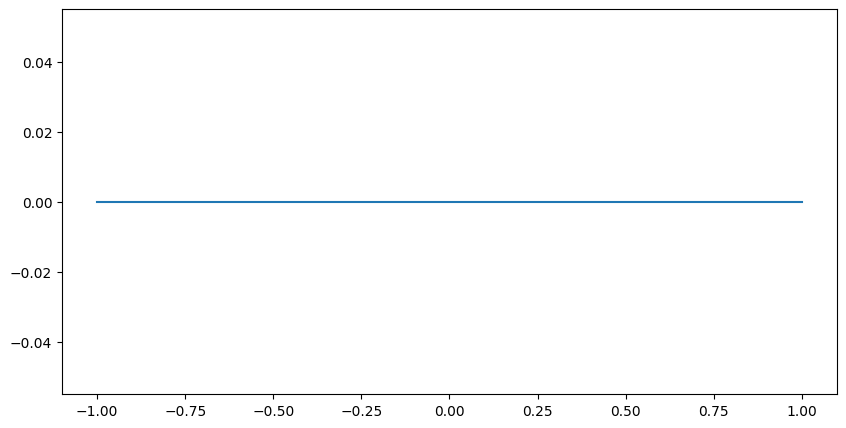

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(xi_list,disco)

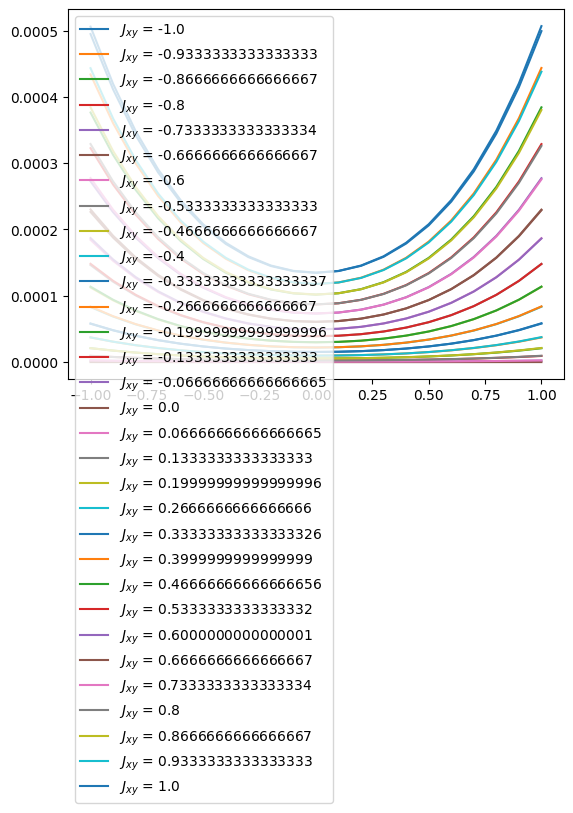

NoiseSynchro_Entropy_Scan_test_0.001.csv


In [82]:
plt.figure()
stac = []
for n in range(0,len(Jxy_list)):
    [s1x,s1y,s1z,s2x,s2y,s2z,em,ecl,disc,disco]=np.transpose(steadystate[n])
    stac.append(em)
    plt.plot(xi_list,em,label=r"$J_{xy}$ = "+str(Jxy_list[n]))
plt.legend(loc="upper left")
plt.show()


filename_ss = f"NoiseSynchro_Entropy_Scan_test_"+str(gamma_val)+".csv"
np.savetxt(filename_ss,stac,delimiter=',')

print(filename_ss)

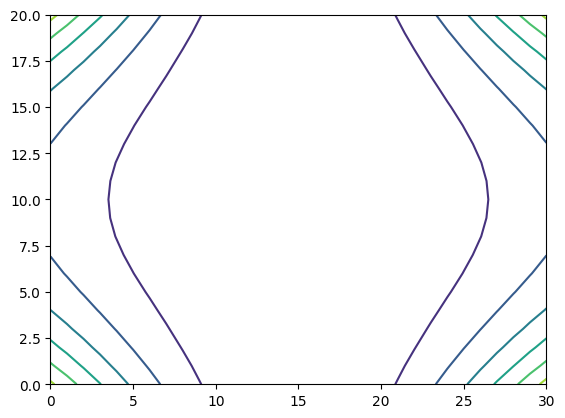

In [83]:
plt.figure()
plt.contour(np.transpose(stac))

## 11-July:  In this section, I want to examine the Discord as the system evolves.

###  Model calculation at $\xi=-1$ and $J_{xy} = 0$

In [323]:
import qutip as qt
import numpy as np

def mutual_information(rho):
    """
    Calculate the mutual information I(A:B) of a bipartite density matrix rho.
    """
    return qt.entropy_mutual(rho, [0], [1])

def strip_off_diagonal(rho):
    """
    Remove the off-diagonal elements of a density matrix rho.
    """
    rho_diag = rho.full() * np.eye(len(rho.full()))
    return qt.Qobj(rho_diag, dims=rho.dims)

def degree_of_quantumness(rho):
    """
    Calculate the Degree of Quantumness of a bipartite density matrix rho and print the matrices.
    """
    #print(f"\n{label} Density Matrix:\n", rho.full())
    
    I_total = mutual_information(rho)
    rho_classical = strip_off_diagonal(rho)
    
    #print(f"\nStripped {label} Density Matrix:\n", rho_classical.full())
    
    I_classical = mutual_information(rho_classical)
    degree_of_quantumness = I_total - I_classical
    
    #print(f"\nDegree of Quantumness for {label}: {degree_of_quantumness}")
    return degree_of_quantumness



In [340]:
# set up the calculation
#

N = 2            # number of spins

# array of spin energy splittings and coupling strengths. here we use
# uniform parameters, but in general we don't have to

hz  = -1.0 * np.ones(N)
hx = .5 * np.ones(N)
Jz = 0. * np.ones(N)
Jx = .25 * np.ones(N)
Jy = .25* np.ones(N)

#hz  = 0 * np.ones(N)
#hx = .5 * np.ones(N)
#Jz = 0. * np.ones(N)
#Jx = 0. * np.ones(N)
#Jy = 0. * np.ones(N)


#-----BATH PARAMETERIZATION -------------
# Local Bath Parameters for
# dE - gamma E dt + sigma dW
gamma_val = .01
gamma =gamma_val * np.ones(N)
sigma = 0.1 * np.ones(N)
gamma1 = .01
#




graph = {
    0:[1],
    1:[0]
}

cor_matrix = create_adjacency_matrix(graph)

ident = np.identity(N)

xi_val = -1


xi_matrix = xi_val*cor_matrix + ident

# pass the xi matrix, sigma, and gamma to the Solver and have the
# collapse operators defined within the subroutine.

tlist = np.linspace(0, 100.0, 500)


# you need to give it an initial excitation:
vacc_list = []
sp_list = []
for n in range(N):
    sp_list.append(qeye(2))
    vacc_list.append(basis(2,0))
vacc = tensor(vacc_list)
vacc_list[0] = basis(2,1)


psi0=tensor(vacc_list)


# |11> \pm |00>
psi0 =(tensor(basis(2,1),basis(2,1)) + tensor(basis(2,0),basis(2,0))).unit()
psi1 =(tensor(basis(2,1),basis(2,1)) - tensor(basis(2,0),basis(2,0))).unit()

#  |10> \pm |01>
phi0 =(tensor(basis(2,1),basis(2,0)) + tensor(basis(2,0),basis(2,1))).unit()
phi1 =(tensor(basis(2,1),basis(2,0)) - tensor(basis(2,0),basis(2,1))).unit()


print("0")
rho0 = SynchroDensityMatrix(N, hx,hz, Jx, Jy, Jz, psi0, tlist, gamma1,gamma, xi_matrix)
print("1")
rho1 = SynchroDensityMatrix(N, hx,hz, Jx, Jy, Jz, psi1, tlist, gamma1,gamma, xi_matrix)
print("2")
rho2 = SynchroDensityMatrix(N, hx,hz, Jx, Jy, Jz, phi0, tlist, gamma1,gamma, xi_matrix)
print("3")
rho3 = SynchroDensityMatrix(N, hx,hz, Jx, Jy, Jz, phi1, tlist, gamma1,gamma, xi_matrix)
nrho = len(rho0)
dat0 = []
dat1 = []
dat2 = []
dat3 = []
for i in range(nrho):

    rho = rho0
    entr = qutip.entropy_mutual(rho[i],0,1)
    rhoA = rho[i].ptrace(1)
    rhoB = rho[i].ptrace(0)
    econBA = qutip.entropy_conditional(rho[i],1)
    econAB = qutip.entropy_conditional(rho[i],0)
    SvnB = qutip.entropy_vn(rhoB)
    SvnA = qutip.entropy_vn(rhoA)
    Ja = SvnB - econBA
    Jb = SvnA - econAB
    

    concur = qutip.concurrence(rho[i])


    deg = degree_of_quantumness(rho[i])
    dat0.append([entr,Ja,Jb,concur,deg])


    rho = rho1
    entr = qutip.entropy_mutual(rho[i],0,1)
    rhoA = rho[i].ptrace(1)
    rhoB = rho[i].ptrace(0)
    econBA = qutip.entropy_conditional(rho[i],1)
    econAB = qutip.entropy_conditional(rho[i],0)
    SvnB = qutip.entropy_vn(rhoB)
    SvnA = qutip.entropy_vn(rhoA)
    Ja = SvnB - econBA
    Jb = SvnA - econAB
    deg = degree_of_quantumness(rho[i])

    

    concur = qutip.concurrence(rho[i])
    dat1.append([entr,Ja,Jb,concur,deg])

    rho = rho2
    entr = qutip.entropy_mutual(rho[i],0,1)
    rhoA = rho[i].ptrace(1)
    rhoB = rho[i].ptrace(0)
    econBA = qutip.entropy_conditional(rho[i],1)
    econAB = qutip.entropy_conditional(rho[i],0)
    SvnB = qutip.entropy_vn(rhoB)
    SvnA = qutip.entropy_vn(rhoA)
    deg = degree_of_quantumness(rho[i])

 

    concur = qutip.concurrence(rho[i])
    dat2.append([entr,Ja,Jb,concur,deg])
    
    rho = rho3
    entr = qutip.entropy_mutual(rho[i],0,1)
    rhoA = rho[i].ptrace(1)
    rhoB = rho[i].ptrace(0)
    econBA = qutip.entropy_conditional(rho[i],1)
    econAB = qutip.entropy_conditional(rho[i],0)
    SvnB = qutip.entropy_vn(rhoB)
    SvnA = qutip.entropy_vn(rhoA)
    Ja = SvnB - econBA
    Jb = SvnA - econAB
    discordA = Ja - entr
    discordB = Jb - entr
    deg = degree_of_quantumness(rho[i])

    concur = qutip.concurrence(rho[i])
    dat3.append([entr,Ja,Jb,concur,deg])






data0 = np.transpose(dat0)
data1 = np.transpose(dat1)
data2 = np.transpose(dat2)
data3 = np.transpose(dat3)



filename0 = f"NoiseSynchro_Entropy_standard_psi+_"+str(xi_val)+".csv"
filename1 = f"NoiseSynchro_Entropy_standard_psi-_"+str(xi_val)+".csv"
filename2 = f"NoiseSynchro_Entropy_standard_phi+_"+str(xi_val)+".csv"
filename3 = f"NoiseSynchro_Entropy_standard_phi-_"+str(xi_val)+".csv"
np.savetxt(filename0,data0,delimiter=',')
np.savetxt(filename1,data1,delimiter=',')
np.savetxt(filename2,data2,delimiter=',')
np.savetxt(filename3,data3,delimiter=',')
print(filename0)
print(filename1)
print(filename2)
print(filename3)



0
 Total run time:   0.87s*] Elapsed 0.87s / Remaining 00:00:00:00[*********37%           ] Elapsed 0.42s / Remaining 00:00:00:00
1
 Total run time:   1.00s*] Elapsed 1.00s / Remaining 00:00:00:00[*****    22%           ] Elapsed 0.17s / Remaining 00:00:00:00[******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00[******   27%           ] Elapsed 0.24s / Remaining 00:00:00:00[*********58%*          ] Elapsed 0.57s / Remaining 00:00:00:00[*********91%*********  ] Elapsed 0.78s / Remaining 00:00:00:00[*********91%*********  ] Elapsed 0.79s / Remaining 00:00:00:00[*********96%********** ] Elapsed 0.97s / Remaining 00:00:00:00[*********97%********** ] Elapsed 0.97s / Remaining 00:00:00:00[*********98%***********] Elapsed 0.98s / Remaining 00:00:00:00
2
 Total run time:   0.74s*] Elapsed 0.74s / Remaining 00:00:00:00[*********71%****       ] Elapsed 0.54s / Remaining 00:00:00:00[*********72%*****      ] Elapsed 0.55s / Remaining 00:00:00:00[*********73%*****      ] Elapsed 0.56s / Re

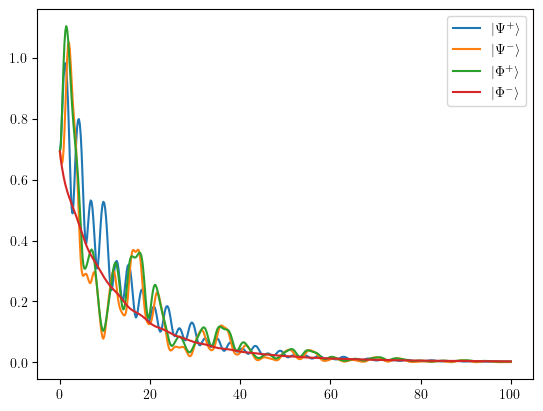

In [338]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.figure()

plt.plot(tlist,data0[4],label=r"$|\Psi^{+}\rangle$")
plt.plot(tlist,data1[4],label=r"$|\Psi^{-}\rangle$")
plt.plot(tlist,data2[4],label=r"$|\Phi^{+}\rangle$")
plt.plot(tlist,data3[4],label=r"$|\Phi^{-}\rangle$")

plt.legend()
plt.show()

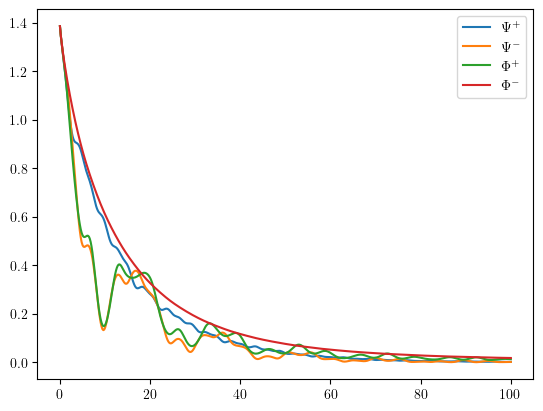

In [339]:
plt.figure()

plt.plot(tlist,data0[0],label=r"$\Psi^{+}$")
plt.plot(tlist,data1[0],label=r"$\Psi^{-}$")
plt.plot(tlist,data2[0],label=r"$\Phi^{+}$")
plt.plot(tlist,data3[0],label=r"$\Phi^{-}$")

plt.legend()
plt.show()